What is `torch.autograd.grad`?

`backward()` is an alias of `torch.autograd.grad` returning gradients w.r.t to ALL leaf tensors which require grad

What is it doing?

It accumulates a `computation graph` which tracks the sequence of tensor operations




The main arguments of `autograd.grad`:

`outputs (sequence of Tensor)` – outputs of the differentiated function.

`inputs (sequence of Tensor or GradientEdge)` – Inputs w.r.t. which the gradient will be returned (and not accumulated into .grad).

`grad_outputs (sequence of Tensor)` – The “vector” in the vector-Jacobian product. Usually gradients w.r.t. each output. None values can be specified for scalar Tensors or ones that don’t require grad. If a None value would be acceptable for all grad_tensors, then this argument is optional. Default: None.

In [30]:
import torch
from torchviz import make_dot
import pyqtorch as pyq

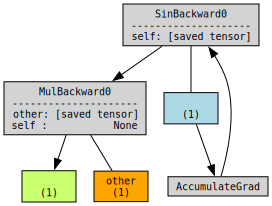

In [45]:
x = torch.rand(1, requires_grad=True)
y = torch.rand(1) # Does not require grad
w = torch.sin(x)
z = w * y

make_dot(z, show_attrs=True, show_saved=True)

# print(x.grad)
# print(y.grad) # None since it does not require grad

Two important arguments of `torch.autograd.grad`:

`retain_graph (bool, optional)` – If False, the graph used to compute the grad will be freed. Note that in nearly all cases setting this option to True is not needed and often can be worked around in a much more efficient way. Defaults to the value of create_graph.


`create_graph (bool, optional)` – If True, graph of the derivative will be constructed, allowing to compute higher order derivative products. Default: False.

When to use `create_graph`?

In [44]:
# For higher order derivatives! We specifically tell torch to 
# construct a new comp graph for the gradient calculation (which is not done by default to save memory)
x = torch.rand(1, requires_grad=True)
w = torch.sin(x)
y = torch.log(x)
z = w * y
dzdx = torch.autograd.grad(z, x, torch.ones_like(z), create_graph=True)[0]
dzdxx = torch.autograd.grad(dzdx, x, torch.ones_like(dzdx))

When to use `retain_graph`?

In [46]:
# For cases where you want to re-use the already computed graph
a = torch.rand((1, 4), requires_grad=True)
b = a**2
c = b*2
d = c.mean()
e = c.sum()

![The resulting computation graph](https://i.stack.imgur.com/Stmud.png)

In [47]:
d.backward(retain_graph=True)
e.backward()

This fails since after the computation of `d.backward()`, the parts of the graph that calculate `d` will be freed by default to save memory.

So whats pyq doing then?

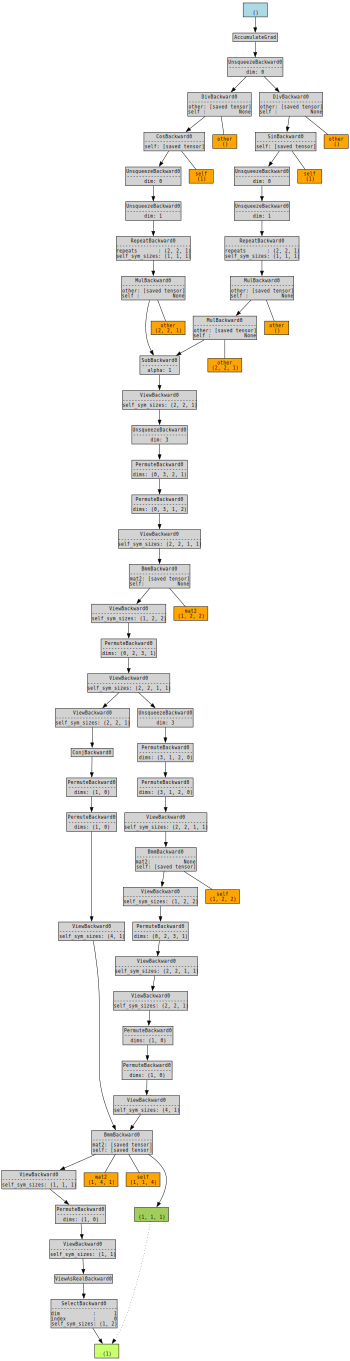

In [50]:
ry = pyq.RY(0, param_name="theta")
n_qubits = 2
circ = pyq.QuantumCircuit(n_qubits, [ry])
obs = pyq.QuantumCircuit(n_qubits, [pyq.Z(0)])
state = pyq.zero_state(n_qubits)
theta  =torch.tensor(torch.pi / 2, requires_grad=True)
exp_ad = pyq.expectation(circ, state, {"theta": theta}, obs, 'ad')
# dfdtheta = torch.autograd.grad(exp_ad, theta, torch.ones_like(exp_ad))[0]
make_dot(exp_ad, show_attrs=True, show_saved=True)

Uff, thats quite a bit of stuff happening. Lets write it a bit simpler

In [51]:
IMAT = torch.eye((2), dtype=torch.complex128)
ZMAT = torch.tensor([[1, 0], [0, -1]], dtype=torch.complex128)
YMAT = torch.tensor([[0, -1j], [1j, 0]], dtype=torch.complex128)

state = torch.tensor([1.+0.j, 0.+0.j], dtype=torch.complex128)

theta = torch.rand(1, requires_grad=True)

operator = torch.cos(theta / 2) * IMAT - 1j * torch.sin(theta / 2) * YMAT

state = operator @ state

projected_state = ZMAT @ state
f = torch.sum(state * projected_state).real
# dfdtheta = torch.autograd.grad(f, theta, torch.ones_like(f))[0]
# Use dfdtheta to minimize some cost-function

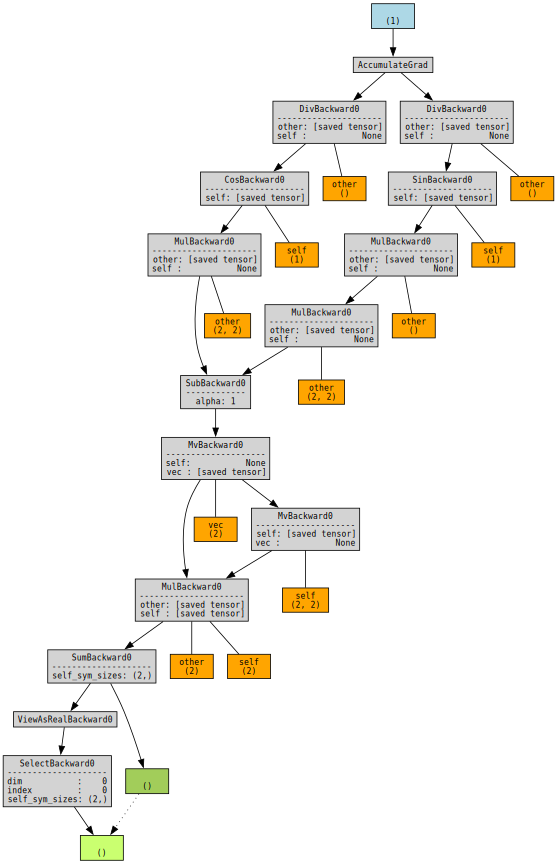

In [52]:
make_dot(f, show_attrs=True, show_saved=True)

So where is the memory overhead of using automatic differentiation for state vector simulators?

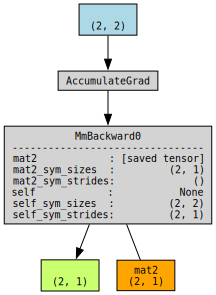

In [58]:
mat = torch.rand((2,2), requires_grad=True)
state = torch.rand((2,1))
new_state = torch.matmul(mat,  state)
make_dot(new_state, show_attrs=True, show_saved=True)

Apparently, we are saving a copy of `mat2` which is our initial state.

In [59]:
mat = torch.rand((2,2), requires_grad=True)
state = torch.rand((2,1))
new_state = torch.matmul(mat,  state)
torch.equal(new_state.grad_fn._saved_mat2, state)

True

Remember the pyq graph for applying a single `RY` and computing expectation using `Z`? Everytime we use `tensordot`/ `einsum` which are just more generic versions of `matmul`, we have to store the intermediate state to calculate the partial derivatives w.r.t to our operators.

Ok, so how does this look like for the `adjoint` method?

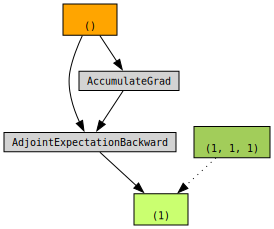

In [60]:
ry = pyq.RY(0, param_name="theta")
n_qubits = 2
circ = pyq.QuantumCircuit(n_qubits, [ry])
obs = pyq.QuantumCircuit(n_qubits, [pyq.Z(0)])
state = pyq.zero_state(n_qubits)
theta  =torch.tensor(torch.pi / 2, requires_grad=True)
exp_ad = pyq.expectation(circ, state, {"theta": theta}, obs, 'adjoint')
# dfdtheta = torch.autograd.grad(exp_ad, theta, torch.ones_like(exp_ad))[0]
make_dot(exp_ad, show_attrs=True, show_saved=True)